### HW1

Первое ДЗ связано с обучением с подкреплением, и оно придумано для ситуации, когда нейронные сети ещё не нужны, и пространство состояний в целом достаточно маленькое, чтобы можно было обучить хорошую стратегию методами TD-обучения или другими методами обучения с подкреплением. 

In [2]:
from collections import OrderedDict, defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random
import copy
import math
import sys
import os

import gym.envs.toy_text.blackjack as bj
from gym.utils import seeding
from gym import spaces
import gym

%matplotlib inline
%load_ext Cython

In [2]:
# !pip install gym

In [3]:
# env = gym.make('Blackjack-v0', natural=True) 
# error message: DeprecatedEnv: Env Blackjack-v0 not found (valid versions include ['Blackjack-v1']) 
env = gym.make('Blackjack-v1', natural=True)

### Часть первая, с блекджеком и стратегиями

Мы будем обучаться играть в очень простую, но знаменитую и популярную игру: блекджек. 
Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:
- численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
- туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;
- игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
- игрок может совершать одно из двух действий:
-- hit  — взять ещё одну карту;
-- stand — не брать больше карт;
- если сумма очков у игрока на руках больше 21, он проигрывает (bust);
- если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
- после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
- в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).

- Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.
- Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.
- Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

### Часть вторая, удвоенная
- В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:
- double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.
- Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.
- Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

### Часть третья, в главной роли — Дастин Хоффман
А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.
 - Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).
Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


### 1. Стратегия: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit

In [4]:
def policy0(state):
    return 0 if state[0] >= 19 else 1

def run_episode(policy):
    episode = list()
    state = env.reset()
    done = False
    while not done:
        action = policy(state)
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        
    return episode


def mc_policy_eval(policy, n_episodes=100000, gamma=1.0):
    res_sum = defaultdict(float)
    N = defaultdict(int)
    V = defaultdict(float)
    aver_rewards, iters = list(), list()
    sum_reward = 0
    
    for i in range(1, n_episodes+1):
        episode = run_episode(policy)
        episode.reverse()
                
        sum_reward += episode[0][2]
        if i % (n_episodes // 10.0) == 0: 
            aver_rewards.append(sum_reward / i)
            iters.append(i)
        G = 0
        for state, action, reward in episode:
            G = gamma * G + reward
            res_sum[state] += G
            N[state] += 1
            V[state] = res_sum[state] / N[state]

    return V, [iters, aver_rewards]


In [5]:
V, points = mc_policy_eval(policy0)
print('Aver reward is: ', points[-1][-1])

Aver reward is:  -0.19597


In [6]:
def draw_plot(*points):
    plt.rcParams["font.size"] = "16" 
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.ylabel("Aver reward")
    plt.xlabel("Iteration number")
    for i in points:
        plt.plot(i[0], i[1])
    ax.set_yticks([-0.3, -0.25, -0.2, -0.15, -0.1, -0.05, 0.0, 0.05, 0.1])
    ax.grid()
    plt.show()

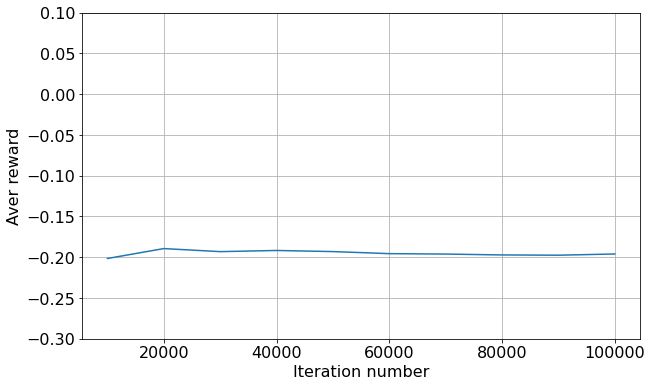

In [7]:
draw_plot(points)

In [8]:
gamma_values = np.arange(0.1, 1.0, 0.4)
for value in gamma_values:
    print("Gamma value:", value)
    V, points = mc_policy_eval(policy0, gamma=value)
    print('Aver reward is: ', points[-1][-1])

Gamma value: 0.1
Aver reward is:  -0.19957
Gamma value: 0.5
Aver reward is:  -0.19717
Gamma value: 0.9
Aver reward is:  -0.19549


In [ ]:
горизонтальная прямая объяснима тем, что мы не обучали стратегию, а использовали детерменированную

### 2. Стратегия: Monte Carlo control every-visit

In [41]:
def decay_eps_generator(min_eps=0.01, decay=0.99999, **kwargs):
    eps = 1.0
    while eps > min_eps:
        yield eps
        eps *= decay
    while 1:
        yield min_eps

def const_eps(**kwargs):
    if kwargs.get("min_eps"):
        eps = kwargs['min_eps']
    elif kwargs.get("eps"):
        eps = kwargs['eps']
    else:
        eps = 0.01
    while 1:
        yield eps

In [10]:
def policy1(Qs, eps):
    An = len(Qs)
    r_num = random.random()
    return np.argmax(Qs) if eps != 1 and r_num > eps else random.randint(0, An-1)

def gen_stoch_episode(policy, Q, eps):
    episode = list()
    state = env.reset()
    done = False
    while not done:
        action = policy(Q[state], eps)
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
    return episode

def mc_control_q(policy, eps_generator, Q=None, episodes_num=600000, gamma=0.8, lrn=0, **kwargs):
    Q = Q or defaultdict(lambda: np.random.rand(env.action_space.n))
    N = defaultdict(lambda: [0] * env.action_space.n)
    
    eps_gen = eps_generator(n_episodes=episodes_num, **kwargs)  
    sum_reward = 0
    mean_rewards, iters, history = list(), list(), list()
    
    for i in range(1, episodes_num + 1):
        epsilon = next(eps_gen)
        episode = gen_stoch_episode(policy, Q, epsilon)
        episode.reverse()     
        sum_reward += episode[0][2]
        if i % (episodes_num // 10) == 0:
            mean_rewards.append(sum_reward / (episodes_num // 10))
            sum_reward = 0
            iters.append(i)
            history.append(epsilon)
        G = 0
        for state, action, reward in episode:
            G = gamma * G + reward
            N[state][action] += 1
            lrn_rate = 1.0 / (N[state][action] + lrn) 
            
            Q[state][action] += lrn_rate * (G - Q[state][action])

    return iters, mean_rewards, history

In [11]:
%%time
env = gym.make('Blackjack-v1', natural=True) 

# choose min_epsilon
vals = [0.001, 0.005, 0.01, 0.05, 0.1]
min_eps_points = list()
for val in vals:
    res = mc_control_q(policy1, decay_eps_generator, min_epsilon=val)
    min_eps_points.append(res)

CPU times: user 2min 6s, sys: 1.72 s, total: 2min 8s
Wall time: 2min 7s


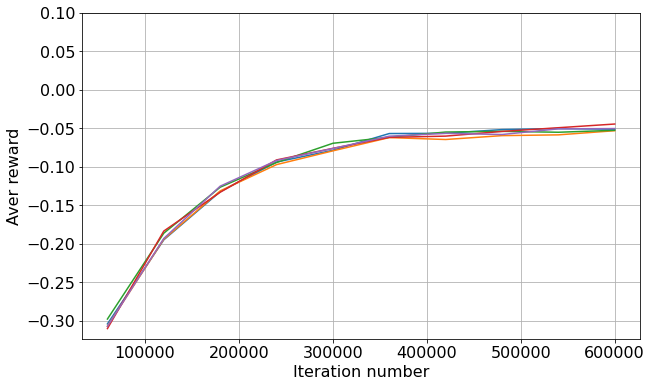

In [13]:
draw_plot(*min_eps_points)

In [15]:
%%time
env = gym.make('Blackjack-v1', natural=True)

# choose gamma
vals = [0.01, 0.1, 0.5, 0.9, 0.99]
gamma_points = list()
for val in vals:
    res = mc_control_q(policy1, decay_eps_generator, gamma=val, min_epsilon=0.01)
    gamma_points.append(res)

CPU times: user 2min 9s, sys: 1.78 s, total: 2min 11s
Wall time: 2min 11s


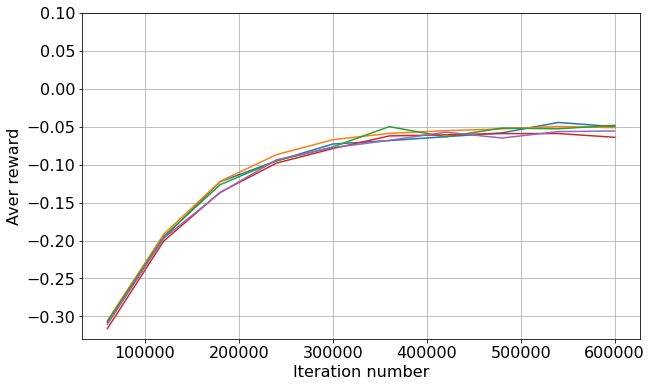

In [16]:
draw_plot(*gamma_points)

In [17]:
%%time
env = gym.make('Blackjack-v1', natural=True)

points = mc_control_q(policy1, decay_eps_generator, episodes_num=750000)
print('Aver reward is: ', points[1][-1])

Aver reward is:  -0.05638666666666667
CPU times: user 32.5 s, sys: 405 ms, total: 32.9 s
Wall time: 32.8 s


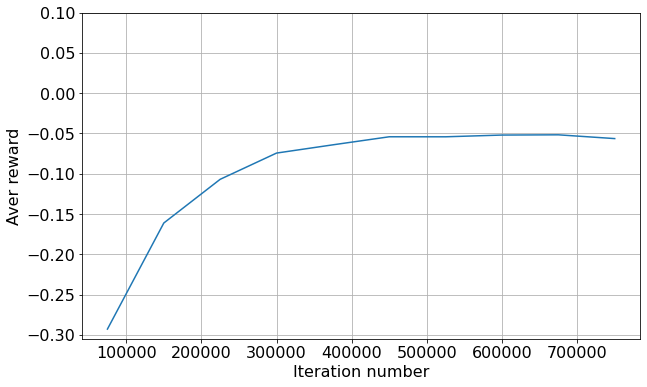

In [18]:
draw_plot(points)

### 4. Hовый вариант блекджека , в котором разрешено удвоение ставки.

In [20]:
class DoubleBlackjackEnv(gym.Env):
    
    def __init__(self, natural=True, sab=False):
        self.natural = natural
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((spaces.Discrete(32), spaces.Discrete(11),spaces.Discrete(2)))
        self.seed()
        self.sab = sab
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        
        if action == 1:
            self.player.append(bj.draw_card(self.np_random))
            if bj.is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
                
        elif action == 0: 
            done = True
            while bj.sum_hand(self.dealer) < 17:
                self.dealer.append(bj.draw_card(self.np_random))
            reward = bj.cmp(bj.score(self.player), bj.score(self.dealer))
            if self.natural and bj.is_natural(self.player) and reward == 1.0:
                reward = 1.5
    
        elif action == 2:
            self.player.append(bj.draw_card(self.np_random))
            done = True
            if bj.is_bust(self.player):
                reward = -2.0
            else:
                while bj.sum_hand(self.dealer) < 17:
                    self.dealer.append(bj.draw_card(self.np_random))
                reward = bj.cmp(bj.score(self.player), bj.score(self.dealer)) * 2.0
                
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (bj.sum_hand(self.player), self.dealer[0], bj.usable_ace(self.player))

    def reset(self):
        self.dealer = bj.draw_hand(self.np_random)
        self.player = bj.draw_hand(self.np_random)
        return self._get_obs()

In [27]:
env = DoubleBlackjackEnv()
print(env.action_space.n)

3


In [30]:
state = env.reset()
state

(14, 10, False)

In [31]:
env.step(2) 

((20, 10, False), 2.0, True, {})

### 5. Mетод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [32]:
%%time
env = DoubleBlackjackEnv() 
Q_double = defaultdict(lambda: np.random.rand(env.action_space.n))

points = mc_control_q(policy1, decay_eps_generator, Q=Q_double, episodes_num=1200000)
print('Aver reward is:', points[1][-1])

Aver reward is: -0.03485
CPU times: user 50.1 s, sys: 501 ms, total: 50.6 s
Wall time: 50.6 s


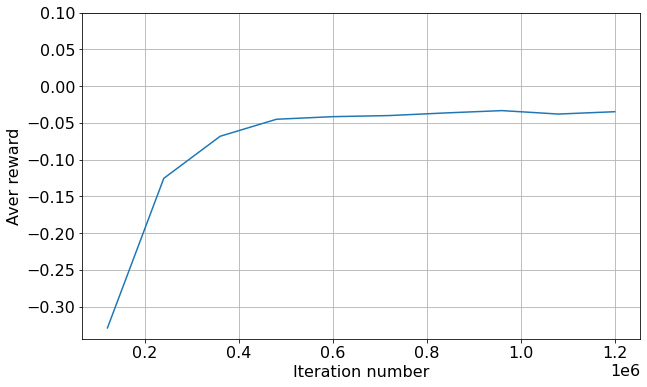

In [33]:
draw_plot(points)

In [34]:
%%time
env = DoubleBlackjackEnv()
# choose min_epsilon
vals = [0.001, 0.005, 0.01, 0.05, 0.1]
min_eps_points = list()
for val in vals:
    res = mc_control_q(policy1, decay_eps_generator, min_epsilon=val)
    min_eps_points.append(res)

CPU times: user 2min 5s, sys: 1.38 s, total: 2min 7s
Wall time: 2min 7s


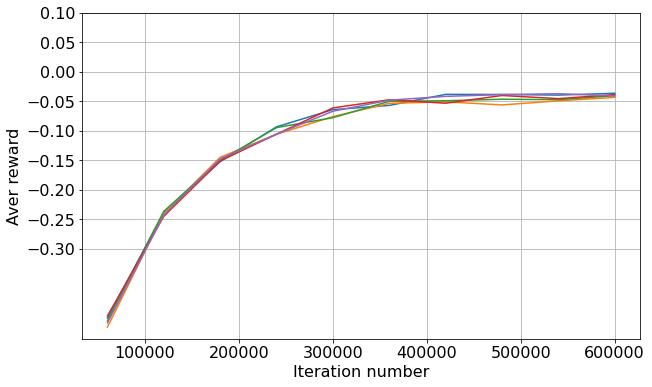

In [35]:
draw_plot(*min_eps_points)


### 6. вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами;

- итак, самый простой и эффективный способ считать карты - хранить число вышедших карт, для этого создадим две переменные - opened и closed. Первая - список известных карт, например opened[0] - число вышедших тузов, а opened[3] - число вышедших десяток (и картинок). Вторая переменная - какая карта у дилера скрыта, добавляем ее в opened после окончания партии. closed = 1 - это туз, closed = 10 - это карта дающая 10 очков.

In [36]:
class DictQ(dict):
    def __missing__(self, state):
        old_state = (state[-3], state[-2], state[-1])
        self[state] = Q_double[old_state].copy()
        return self[state]


class DoubleCountingBlackjackEnv(gym.Env): 
    def __init__(self, natural=True, sab=False):
        self.action_space = spaces.Discrete(3)
        self.sab = sab
        self.observation_space = spaces.Tuple((
            spaces.Discrete(5), 
            spaces.Discrete(17), 
            spaces.Discrete(17), 
            spaces.Discrete(17),
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()
        self.natural = natural
        
        deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
        self.orig_deck = sorted(deck * 4)
        self.deck = copy.copy(self.orig_deck)
        self.opened = [0] * 4
        self.closed = 0
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        
        if action == 1: 
            self.player.append(self.draw_card(self.np_random))
            if self.is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0
                
        elif action == 0:  
            done = True
            while self.sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.np_random))
            reward = self.cmp(self.score(self.player), self.score(self.dealer))
            if self.natural and self.is_natural(self.player) and reward == 1.0:
                reward = 1.5
    
        elif action == 2: 
            self.player.append(self.draw_card(self.np_random))
            done = True
            if self.is_bust(self.player):
                reward = -2.0
            else:
                while self.sum_hand(self.dealer) < 17:
                    self.dealer.append(self.draw_card(self.np_random))
                reward = self.cmp(self.score(self.player), self.score(self.dealer)) * 2.0
        
        return self._get_obs(), reward, done, {}
    
    def cmp(self, a, b):
        return float(a > b) - float(a < b)

    def _get_obs(self):
        return (*self.opened, self.sum_hand(self.player), self.dealer[0], self.usable_ace(self.player))

    def reset(self, full_reset=False):
        if full_reset or len(self.deck) < 15:
            self.deck = copy.copy(self.orig_deck)
            self.opened = [0] * 4
            self.closed = 0
        elif self.closed: 
            if self.closed == 1:
                i = 0
            elif 2 <= self.closed <= 5:
                i = 1
            elif 6 <= self.closed <= 9:
                i = 2
            elif self.closed == 10:
                i = 3
            else:
                assert False            
            self.opened[i] += 1
        self.dealer = self.draw_dealer_hand(self.np_random)
        self.player = self.draw_hand(self.np_random)
        return self._get_obs()


    def draw_card(self, np_random):
        card = self.deck.pop(random.randrange(len(self.deck)))
        if card == 1:
            i = 0
        elif 2 <= card <= 5:
            i = 1
        elif 6 <= card <= 9:
            i = 2
        elif card == 10:
            i = 3
        else:
            raise            
        self.opened[i] += 1 
        return card
    
    def draw_closed(self, np_random):
        card = self.deck.pop(random.randrange(len(self.deck)))
        self.closed = card
        return card

    def draw_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_card(np_random)]
    
    def draw_dealer_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_closed(np_random)]

    def usable_ace(self, hand):  
        return 1 in hand and sum(hand) + 10 <= 21

    def sum_hand(self, hand):  
        if self.usable_ace(hand):
            return sum(hand) + 10
        return sum(hand)

    def is_bust(self, hand): 
        return self.sum_hand(hand) > 21

    def score(self, hand):  
        return 0 if self.is_bust(hand) else self.sum_hand(hand)

    def is_natural(self, hand):  
        return sorted(hand) == [1, 10]

In [37]:
env = DoubleCountingBlackjackEnv()
print(env.action_space.n)
Q_cnt = DictQ()

3


In [38]:
gen_stoch_episode(policy1, Q_cnt, 0.05)

[((0, 2, 4, 1, 7, 6, False), 0, 1.0)]

In [44]:
%%time
env = DoubleCountingBlackjackEnv()
Q_cnt = DictQ()
points = mc_control_q(policy1, const_eps, Q=Q_cnt, episodes_num=300000000, lrn=40)

In [45]:
print('Aver reward is:', points[1][-1])

Aver reward is: -0.056174833333333334


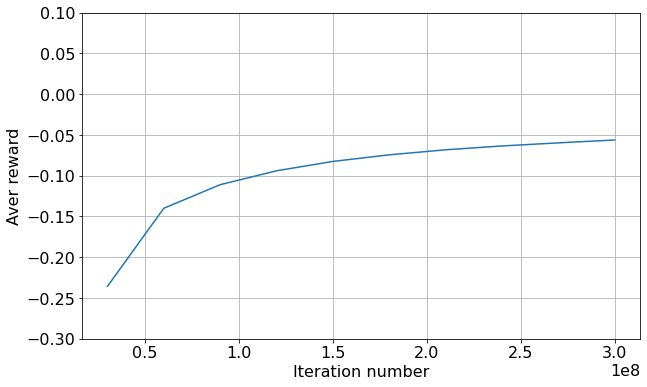

In [47]:
draw_plot(points)

In [50]:
points[1]

[-0.23569635,
 -0.13992376666666667,
 -0.1109864,
 -0.09395591666666667,
 -0.08247656666666667,
 -0.07438265,
 -0.06821788333333334,
 -0.06348633333333334,
 -0.0597071,
 -0.056174833333333334]